# Time Series Analysis

## Problem Statement :
Unicorn Investors wants to make an investment in a new form of transportation - JetRail. JetRail uses Jet propulsion technology to run rails and move people at a high speed! The investment would only make sense, if they can get more than 1 Million monthly users with in next 18 months. In order to help Unicorn Ventures in their decision, you need to forecast the traffic on JetRail for the next 7 months. You are provided with traffic data of JetRail since inception in the test file

## Steps to follow :
1. **Understanding the data**<br>
    a. Hypothesis Testing<br>
    b. Loading the data<br>
    c. Dataset Structure and Content<br>
    d. Feature Extraction<br>
    e. Exploratory Analysis
2. **Forecasting using multiple modelling techniques**<br>
    a. Splitting data into training and validation part<br>
    b. Modelling Techniques<br>
    c. Holt's linear trend model on daily time series<br>
    d. Holt winter's model on daily time series<br>
    e. Introduction to ARIMA model<br>
    f. Parameter tuning for ARIMA model<br>
    g. SARIMAX model on daily time series

## 1. Understanding the data

### a. Hypothesis Generation

Hypothesis generation is done before having a look on the data. It hepls in pointing out the factors which might effect our target variable (in this case, the number of passengers). Some of the hypothesis which i can think of that might affect the passenger count are :<br>
* **Traffic will increase as the year passes by :**<br>
    The population has a general upward trend , so i can expect more people<br> 
    on jetrails as the year passes.
* **Traffic will be high from May to October : **<br>
    Tourist visits generally increase during this time period.
* **Traffic on weekdays will be more as compared to weekends/holidays :**<br>
    People will go to office on weekdays.
* **Traffic during peak hours will be high :**<br>
    People will travel to work/college.
    
### b. Loading the data

In [1]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
import datetime as dt
sns.set()
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

In [2]:
#loading the dataset
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [3]:
#copying the dataset
train_original = train.copy()
test_original = test.copy()

### c. Data structure and Content

In [4]:
#checking the columns in test and train data
print('Training Set columns : {}'.format(list(train.columns)))
print('Testing Set columns : {}'.format(list(test.columns)))

Training Set columns : ['ID', 'Datetime', 'Count']
Testing Set columns : ['ID', 'Datetime']


In [5]:
#check data types of data
print('Training Data dtypes :\n\n',train.dtypes)
print()
print('Testing Data dtypes :\n\n',test.dtypes)

Training Data dtypes :

 ID           int64
Datetime    object
Count        int64
dtype: object

Testing Data dtypes :

 ID           int64
Datetime    object
dtype: object


In [6]:
#check shape of data
print('Train Data Shape : \nRows :{}\nColumns :{}\n'.format(train.shape[0],train.shape[1]))
print('Test Data Shape : \nRows :{}\nColumns :{}'.format(test.shape[0],test.shape[1]))

Train Data Shape : 
Rows :18288
Columns :3

Test Data Shape : 
Rows :5112
Columns :2


### d. Feature Extraction

In [7]:
#change data type of 'Datetime' as date time format to extract features
train['Datetime'] = pd.to_datetime(train['Datetime'], format= '%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test['Datetime'], format= '%d-%m-%Y %H:%M')
train_original['Datetime'] = pd.to_datetime(train_original['Datetime'], format= '%d-%m-%Y %H:%M')
test_original['Datetime'] = pd.to_datetime(test_original['Datetime'], format= '%d-%m-%Y %H:%M')

In [8]:
#extract year, month, day and hour from 'Datetime' to validate our hypothesis
for i in (train, test, train_original, test_original):
    i['year'] = i['Datetime'].dt.year
    i['month'] = i['Datetime'].dt.month
    i['day'] = i['Datetime'].dt.day
    i['Hour'] = i['Datetime'].dt.hour

##### Time to validate our hypothesis

In [9]:
'''
Extract days of the week from Datetime and then based on the values, we will assign whether it is a weekday or not.
'''
train['day of week'] = train['Datetime'].dt.dayofweek
temp = train['Datetime']

In [10]:
#assign 1 if the day of week is weekend and 0 otherwise
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0

In [11]:
temp2 = train['Datetime'].apply(applyer)

In [12]:
train['weekend'] = temp2

**Plotting time series**

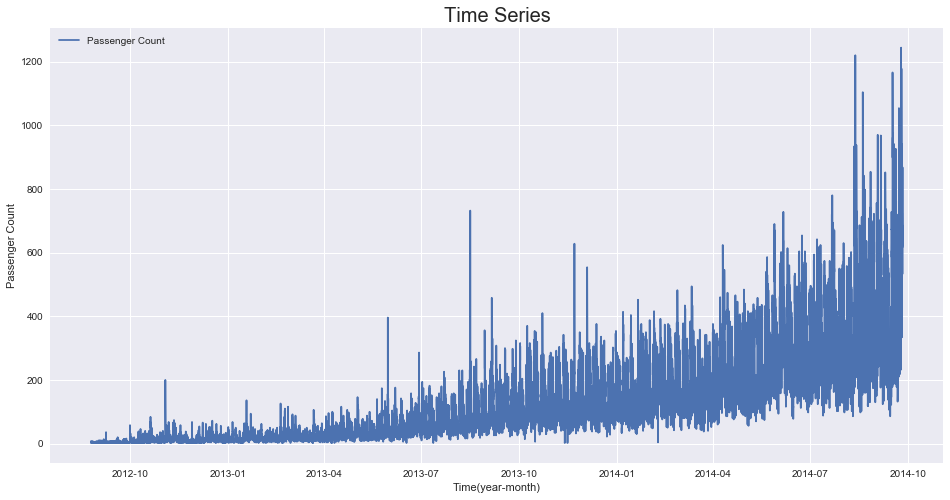

In [13]:
train.index = train['Datetime']#indexing Datetime to get time period on x axis
df = train.drop('ID', axis= 1)#drop ID variable to get only Datetime on x-axis
ts = df['Count']
plt.figure(figsize=(16,8))
plt.plot(ts, label = 'Passenger Count')
plt.title('Time Series', fontsize= 20)
plt.xlabel('Time(year-month)')
plt.ylabel('Passenger Count')
plt.legend(loc= 'best')
plt.savefig('Time Series.jpg')
plt.show()

From the above figure, we can infer that the count of passengers increase with the year.<br>
Hence, our **first hypothesis is validated.**

### e. Exploratory Analysis

Let us now try to verify the hypothesis using actual data

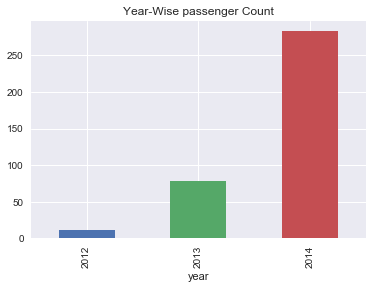

In [14]:
train.groupby('year')['Count'].mean().plot.bar()
plt.title('Year-Wise passenger Count')
plt.show()

From above figure, we can conclude that the count of passengers rises exponentially as the year passes. Hence, our first hypothesis is validated once again.

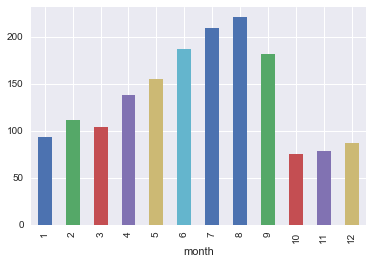

In [15]:
train.groupby('month')['Count'].mean().plot.bar()

From figure, we can see that the average passenger count of passengers is very low in last 3 months. This does'nt seems right. Lets look at monthly mean of each year seperately.

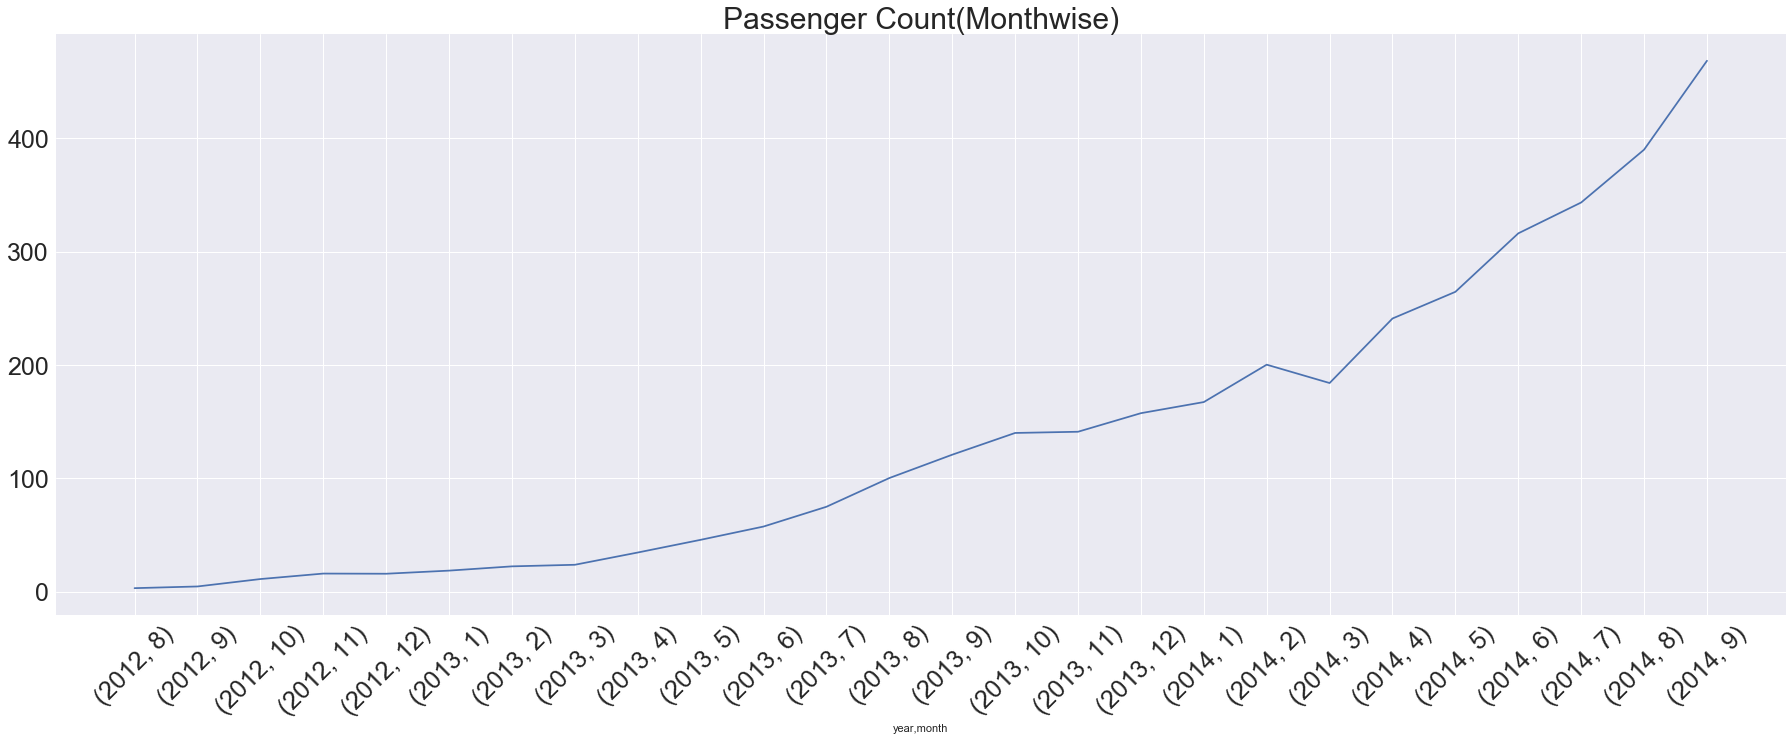

In [16]:
temp = train.groupby(['year','month'])['Count'].mean()
temp.plot(kind='line', figsize=(25,10), fontsize= 25, xticks=np.arange(len(temp)), rot=45)
plt.tight_layout()
plt.title( 'Passenger Count(Monthwise)',fontsize=30)
plt.show()

As it can be seen in the figure that there are no values for months 10, 11 and 12 in 2014. So, the mean of last 3 months was low. It seems that our second hypothesis was also true.

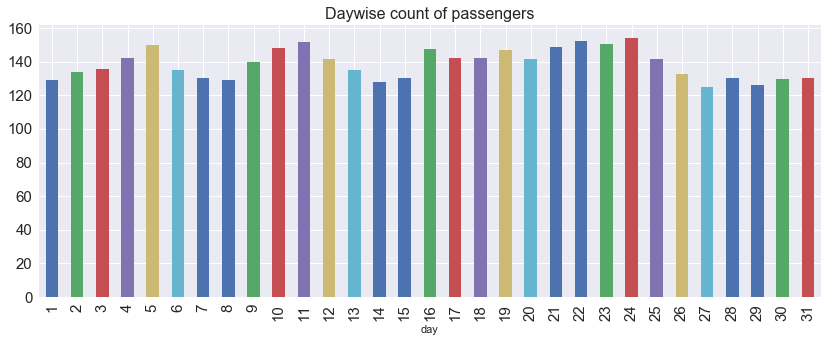

In [17]:
plt.figure(figsize=(14,5))
train.groupby('day')['Count'].mean().plot.bar(fontsize=15)
plt.title('Daywise count of passengers', fontsize= 16)
plt.show()

This doesn't give much insights so we can't reach a strong conclusion.

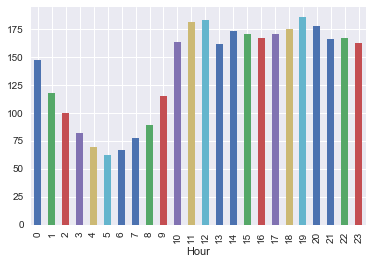

In [18]:
train.groupby('Hour')['Count'].mean().plot.bar()

* It can be inferred that the peak traffic is at 7 PM and then we see a decreasing trend till 5 AM.
* After that the passenger count starts increasing again and peaks again between 11AM and 12 Noon.

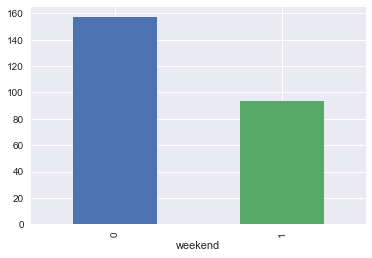

In [19]:
train.groupby('weekend')['Count'].mean().plot.bar()
plt.show()

It can be inferred from the above plot that the traffic is more on weekdays as compared to weekends which validates our hypothesis.

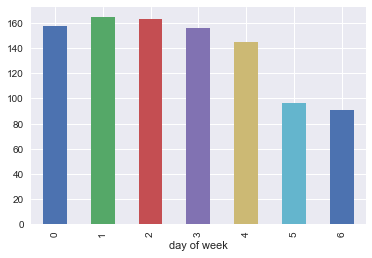

In [20]:
train.groupby('day of week')['Count'].mean().plot.bar()
plt.show()

0 - Monday
6 - Saturday<br>
From the above plot, we can conclude that the passenger count is less for Saturday and Sunday as compare to other days of the week

In [21]:
train = train.drop('ID',1)#as it has no effect on the count of passengers

In [22]:
train['Timestamp'] = pd.to_datetime(train['Datetime'], format='%d-%m-%Y %H:%M')

In [23]:
train.index = train['Timestamp']

In [24]:
#hourly time series
hourly = train.resample('H').mean()
#daily time series
daily = train.resample('D').mean()
#weekly time series
weekly = train.resample('W').mean()
#monthly time series
monthly = train.resample('M').mean()

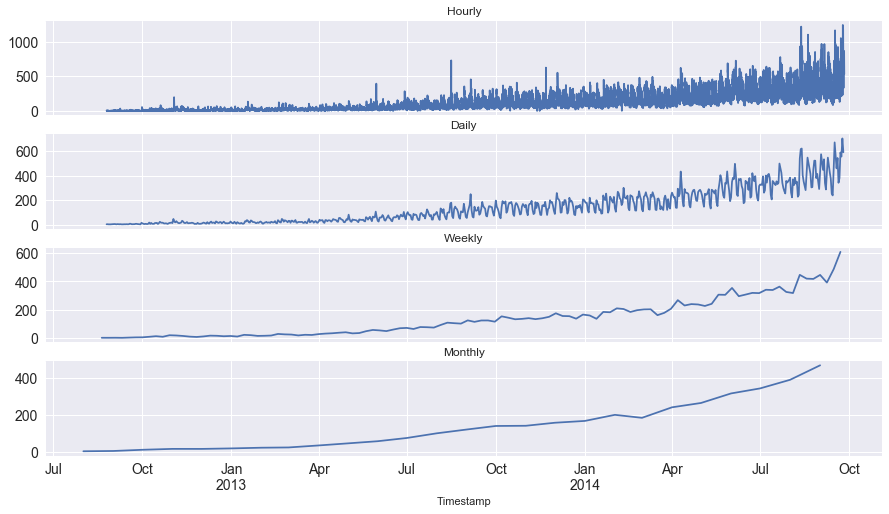

In [25]:
#lets look at all the resampled time series
fig, axes = plt.subplots(4, 1, sharex=True)
hourly['Count'].plot(figsize= (15,8), title= 'Hourly', fontsize= 14, ax= axes[0])
daily['Count'].plot(figsize= (15,8), title= 'Daily', fontsize= 14, ax= axes[1])
weekly['Count'].plot(figsize= (15,8), title= 'Weekly', fontsize= 14, ax= axes[2])
monthly['Count'].plot(figsize= (15,8), title= 'Monthly', fontsize= 14, ax= axes[3])
plt.show()

In [26]:
test['Timestamp'] = pd.to_datetime(test['Datetime'], format='#d-%m-%Y %H:%M')

In [27]:
test.index = test['Timestamp']

In [28]:
test = test.resample('D').mean()

In [29]:
train['Timestamp'] = pd.to_datetime(train['Datetime'], format='%d-%m-%Y %H:%M')

In [30]:
train.index = train['Timestamp']

In [31]:
train = train.resample('D').mean()

## 2. Forecasting Using multiple modelling techniques

### a. Splitting data into training and validation part

To divide the data into training and validation set, we will take last 3 months as the validation data and rest for training data. We will take only 3 months as the trend will be the most in them. If we take more than 3 months for the validation set, our training set will have less data points as the total duration is of 25 months. So, it will be a good choice to take 3 months for validation set.<br><br>
The starting date of the dataset is 25-08-2012 as we have seen in the exploration part and the end date is 25-09-2014.

In [32]:
Train=train.loc['2012-08-25':'2014-06-24'] 
valid=train.loc['2014-06-25':'2014-09-25']

In [33]:
train.shape

(762, 7)

In [34]:
valid.shape

(93, 7)

* We have done time based validation here by selecting the last 3 months for the validation data and rest in the train data. If we would have done it randomly it may work well for the train dataset but will not work effectively on validation dataset.

* Lets understand it in this way: If we choose the split randomly it will take some values from the starting and some from the last years as well. It is similar to predicting the old values based on the future values which is not the case in real scenario. So, this kind of split is used while working with time related problems.


Now we will look at how the train and validation part has been divided.

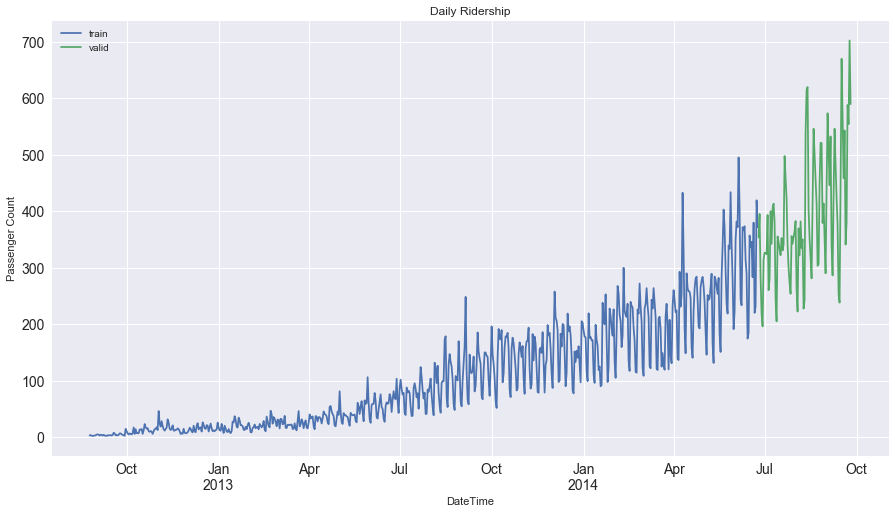

In [35]:
Train['Count'].plot(figsize= (15,8), title= 'Daily Ridership', fontsize= 14, label= 'train')
valid['Count'].plot(figsize= (15,8), title= 'Daily Ridership', fontsize= 14, label= 'valid')
plt.xlabel('DateTime')
plt.ylabel('Passenger Count')
plt.legend(loc= 'best')
plt.show()

### b. Modelling Techniques

We will look at various models now to forecast the time series .

* Naive Approach
* Moving Average
* Simple Exponential Smoothing
* Holt’s Linear Trend Model

#### Naive Approach

In this forecasting technique, we assume that the next expected point is equal to the last observed point. So we can expect a straight horizontal line as the prediction.<br>
Let’s make predictions using naive approach for the validation set.

In [36]:
y_hat = valid.copy()
y_hat['naive'] = Train['Count'][-1]

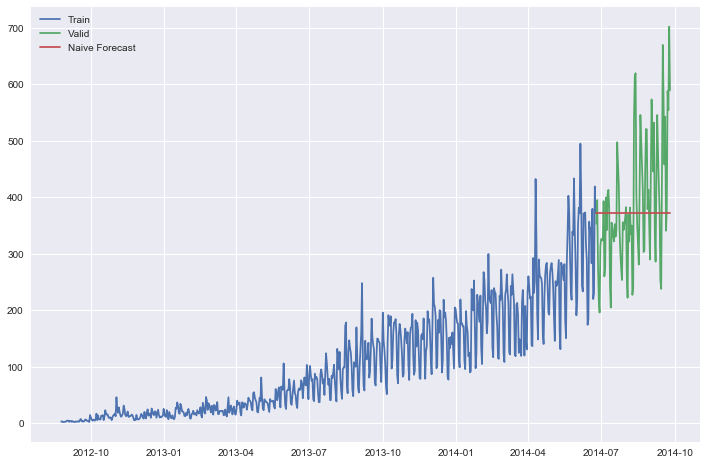

In [37]:
plt.figure(figsize= (12, 8))
plt.plot(Train.index, Train['Count'], label= "Train")
plt.plot(valid.index, valid['Count'], label= "Valid")
plt.plot(y_hat.index, y_hat['naive'], label= "Naive Forecast")
plt.legend(loc= 'best')
plt.show()

We can use ROOT-MEAN-SQUARE(RMSE) as our evaluation matrix

In [38]:
rms = sqrt(mean_squared_error(valid.Count, y_hat.naive))
print(rms)

111.79050467496724


Hence we can say that this method is not suitable for datasets with high variability. We can use other modelling techniques for such high variance datasets.

#### Moving Average

In this technique we will take the average of the passenger counts for last few time periods only.<br>
Lets try the rolling mean for last 10, 20, 50 days and visualize the results.

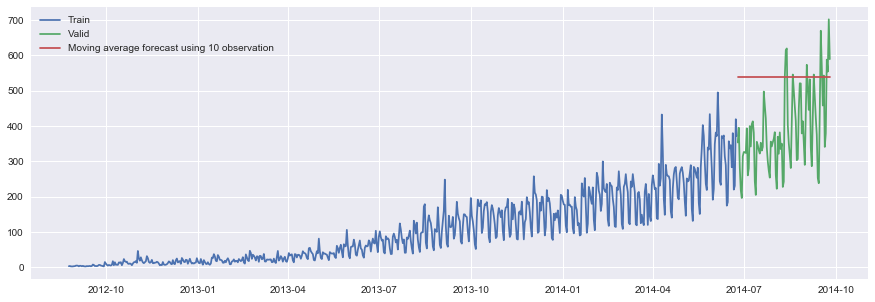

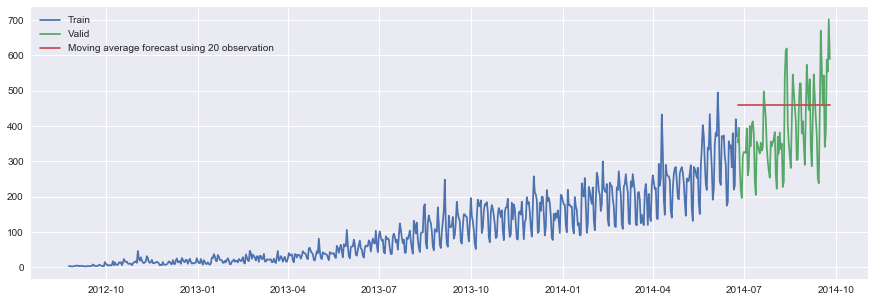

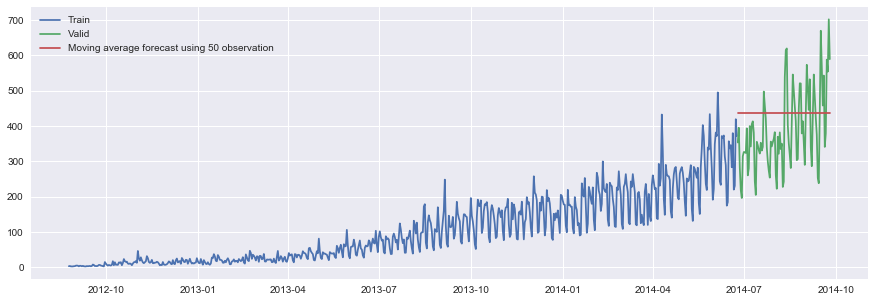

In [39]:
y_hat_average = valid.copy()
y_hat_average['moving_avg_forecast'] = train['Count'].rolling(10).mean().iloc[-1] #average of last 10 observation
plt.figure(figsize=(15,5))
plt.plot(Train['Count'], label= 'Train')
plt.plot(valid['Count'], label= 'Valid')
plt.plot(y_hat_average['moving_avg_forecast'], label= 'Moving average forecast using 10 observation')
plt.legend(loc= 'best')
plt.show()
y_hat_average = valid.copy()
y_hat_average['moving_avg_forecast'] = train['Count'].rolling(20).mean().iloc[-1] #average of last 20 observation
plt.figure(figsize=(15,5))
plt.plot(Train['Count'], label= 'Train')
plt.plot(valid['Count'], label= 'Valid')
plt.plot(y_hat_average['moving_avg_forecast'], label= 'Moving average forecast using 20 observation')
plt.legend(loc= 'best')
plt.show()
y_hat_average = valid.copy()
y_hat_average['moving_avg_forecast'] = train['Count'].rolling(50).mean().iloc[-1] #average of last 10 observation
plt.figure(figsize=(15,5))
plt.plot(Train['Count'], label= 'Train')
plt.plot(valid['Count'], label= 'Valid')
plt.plot(y_hat_average['moving_avg_forecast'], label= 'Moving average forecast using 50 observation')
plt.legend(loc= 'best')
plt.show()

We can see that the predictions are getting weaker as we increase the number of observation.

In [40]:
rms = sqrt(mean_squared_error(valid.Count,y_hat_average['moving_avg_forecast']))
print(rms)

120.4085374880036


#### Simple Exponential Smoothing

* In this technique, we assign larger weights to more recent observations than to observations from the distant past.
* The weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations.

**NOTE** - If we give the entire weight to the last observed value only, this method will be similar to the naive approach. So, we can say that naive approach is also a simple exponential smoothing technique where the entire weight is given to the last observed value.

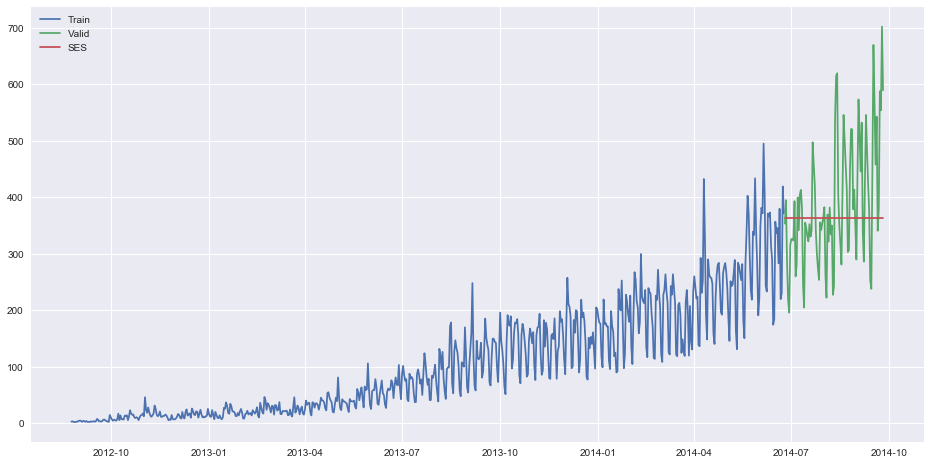

In [41]:
y_hat_avg = valid.copy()
fit2 = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level= 0.6, optimized= False)
y_hat_avg['SES'] = fit2.forecast(len(valid))
plt.figure(figsize= (16,8))
plt.plot(Train['Count'], label= 'Train')
plt.plot(valid['Count'], label= 'Valid')
plt.plot(y_hat_avg['SES'], label= 'SES')
plt.legend(loc= 'best')
plt.show()

In [42]:
rms = sqrt(mean_squared_error(valid['Count'], y_hat_avg['SES']))
print(rms)

113.43708111884514


#### Holt's Linear trend model

* It is an extension of simple exponential smoothing to allow forecasting of data with a trend.
* This method takes into account the trend of the dataset. The forecast function in this method is a function of level and trend.

First of all let us visualize the trend, seasonality and error in the series.

We can decompose the time series in four parts.

* Observed, which is the original time series.
* Trend, which shows the trend in the time series, i.e., increasing or decreasing behaviour of the time series.
* Seasonal, which tells us about the seasonality in the time series.
* Residual, which is obtained by removing any trend or seasonality in the time series.

In [43]:
import statsmodels.api as sm

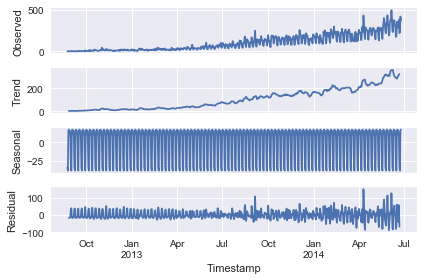

In [44]:
sm.tsa.seasonal_decompose(Train['Count']).plot()
result = sm.tsa.stattools.adfuller(train['Count'])
plt.show()

An increasing trend can be seen in the dataset, so now we will make a model based on the trend.

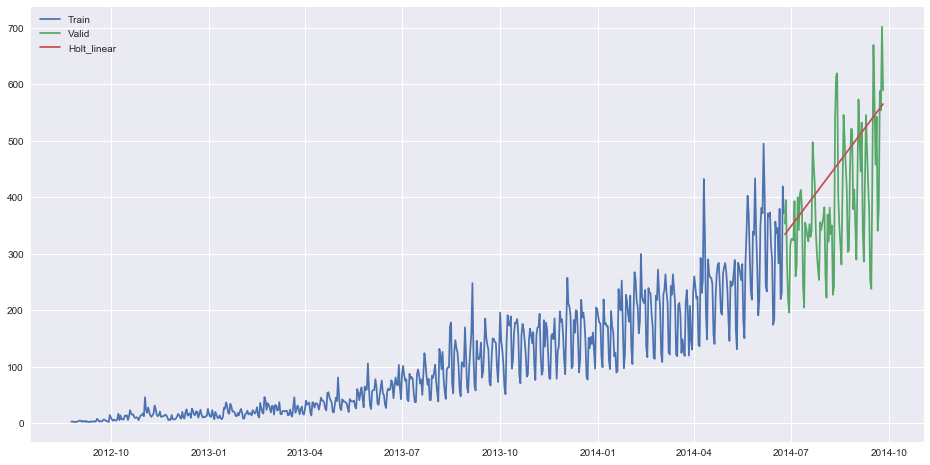

In [45]:
y_hat_avg = valid.copy()
fit1 = Holt(np.asarray(Train['Count'])).fit(smoothing_level= 0.3, smoothing_slope= 0.1)
y_hat_avg['Holt linear'] = fit1.forecast(len(valid))
plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label= 'Train')
plt.plot(valid['Count'], label= 'Valid')
plt.plot(y_hat_avg['Holt linear'], label= 'Holt_linear')
plt.legend(loc= 'best')
plt.show()

In [46]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg['Holt linear'])) 
print(rms)

112.94278345314041


### c. Holt's Linear Trend Model on Daily Time Series

* Now let’s try to make holt’s linear trend model on the daily time series and make predictions on the test dataset.
* We will make predictions based on the daily time series and then will distribute that daily prediction to hourly predictions.
* We have fitted the holt’s linear trend model on the train dataset and validated it using validation dataset.

Now let’s load the submission file.

In [47]:
submission = pd.read_csv('Sample_Submission.csv')

In [48]:
predict = fit1.forecast(len(test))

In [49]:
test['prediction'] = predict

Remember this is the daily predictions. We have to convert these predictions to hourly basis. * To do so we will first calculate the ratio of passenger count for each hour of every day. * Then we will find the average ratio of passenger count for every hour and we will get 24 ratios. * Then to calculate the hourly predictions we will multiply the daily prediction with the hourly ratio.

In [50]:
#calculating the hourly ratio of count
train_original['ratio'] = train_original['Count']/train_original['Count'].sum()
#grouping the hourly ratio
temp = train_original.groupby(['Hour'])['ratio'].sum()

In [51]:
#groupby to csv format
pd.DataFrame(temp, columns=['Hour','ratio']).to_csv('Groupby.csv')

In [52]:
temp2 = pd.read_csv('Groupby.csv')

In [53]:
temp2 = temp2.drop('Hour.1', axis= 1)

In [54]:
#merge test and test_original on day, month, year
merge = pd.merge(test, test_original, on= ('day','month','year'), how= 'left')

In [55]:
merge['Hour'] = merge['Hour_y']

In [56]:
merge = merge.drop(['year','month','Datetime','Hour_x','Hour_y'],axis= 1)

In [57]:
prediction = pd.merge(merge, temp2, on= 'Hour', how= 'left')

In [58]:
#converting the ratio to original scale
prediction['Count'] = prediction['prediction']*prediction['ratio']*24
prediction['ID'] = prediction['ID_y']

In [59]:
#drop all other features and keep id and count only
submission = prediction.drop(['ID_x', 'day', 'prediction', 'ID_y', 'Hour', 'ratio'], axis= 1)

In [60]:
#convert final submission to final format
pd.DataFrame(submission, columns=['ID','Count']).to_csv("Holt's linear.csv")

### d. Holt Winter's model on daily time series

* Datasets which show a similar set of pattern after fixed intervals of a time period suffer from seasonality.

* The above mentioned models don’t take into account the seasonality of the dataset while forecasting. Hence we need a method that takes into account both trend and seasonality to forecast future prices.

* One such algorithm that we can use in such a scenario is Holt’s Winter method. The idea behind Holt’s Winter is to apply exponential smoothing to the seasonal components in addition to level and trend.

Let’s first fit the model on training dataset and validate it using the validation dataset.

In [61]:
y_hat_avg = valid.copy()
fit1 = ExponentialSmoothing(np.asarray(Train['Count']), seasonal_periods= 7, trend= 'add', seasonal= 'add').fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(valid))

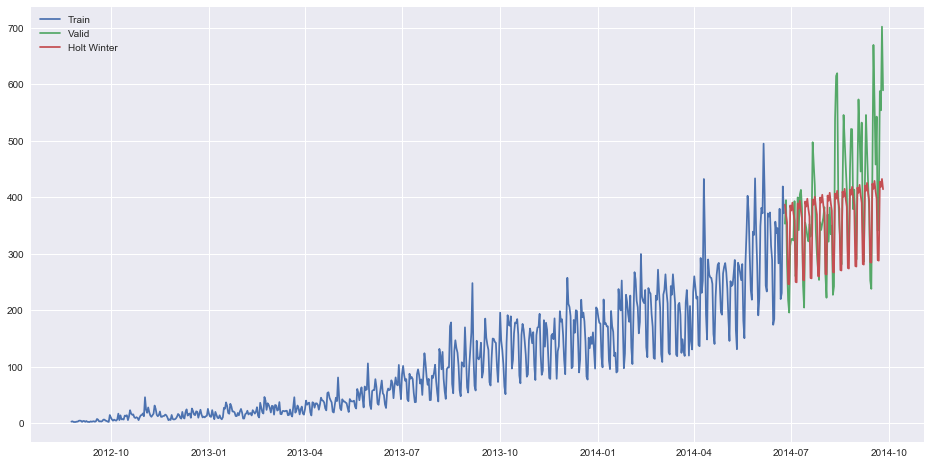

In [62]:
plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label= 'Train')
plt.plot(valid['Count'], label= 'Valid')
plt.plot(y_hat_avg['Holt_Winter'], label= 'Holt Winter')
plt.legend(loc= 'best')
plt.show()

In [63]:
rms = sqrt(mean_squared_error(valid['Count'], y_hat_avg['Holt_Winter']))
print(rms)

82.37826583279276


In [64]:
predict = fit1.forecast(len(test))

Now we will convert these daily passenger count into hourly passenger count using the same approach which we followed above.

In [65]:
test['prediction'] = predict

In [66]:
#merge test and test_original on day, month and year
merge = pd.merge(test, test_original, on= ('day','month','year'), how= 'left')

In [67]:
merge['Hour'] = merge['Hour_y']

In [68]:
merge.drop(['year', 'month','Hour_x','Datetime', 'Hour_y'], axis= 1, inplace= True)

In [69]:
#predicting by merging merge and temp2
prediction = pd.merge(merge, temp2, on= 'Hour', how= 'left')

In [70]:
#converting the ratio to original scale
prediction['Count'] = prediction['prediction']*prediction['ratio']*24

In [71]:
#Let’s drop all features other than ID and Count
prediction['ID'] = prediction['ID_y']

In [72]:
submission = prediction.drop(['day','Hour','ratio','prediction', 'ID_x', 'ID_y'],axis=1)

In [73]:
#converting final submission to csv format
pd.DataFrame(submission, columns=['ID','Count']).to_csv('Holt Winters.csv')

The model doesn't performed well in public leaderboard even its rmse is much smaller. The possible reason behing this may be because the model was not that good in predicting the trend of the time series but worked really well on the seasonality part.

### e. Introduction to ARIMA model

**ARIMA** stands for **Auto Regression Integrated Moving Average**. It is specified by three ordered parameters : p,d,q.
* **p** is the order of auto-regressive model(number of time lags)
* **d** is the degree of differencing(number of times the data have had past values subtracted.)
* **q** is the order of moving average model.

The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation.

**Stationary Time Series :**<br>
Criterion for a series to be a stationary time series are :
* The mean of time series should be constant and not the function of time.
* The variance of time series should not be a function of time.
* The covariance of ith term and (i+m)th term should not be a function of time.

**Reason to make time series stationary :**
We make time series stationary to make the variables independent. Variables can be dependent in many ways but can be independent in only one way. So we will get more information when they are independent. Hence the time series must be stationary.

If the time series is not stationary, firstly we will have to make it stationary. For doing so, we need to remove the trend and seasonality from the data.

### f. Parameter tuning for ARIMA model
First of all we have to make sure that the time series is stationary. If it is not stationary, then we will have to make it stationary.

* We can use the **Dickey fuller test** to check the stationarity of the series.
* The intuition behind this test is that it determines how strongly a time series is defined by a trend.
* The null hypothesis of the test is that time series is not stationary (has some time-dependent structure).
* The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.<br>
We interpret this result using the Test Statistics and critical value. If the Test Statistics is smaller than critical value, it suggests we reject the null hypothesis (stationary), otherwise a greater Test Statistics suggests we accept the null hypothesis (non-stationary).

Let’s make a function which we can use to calculate the results of Dickey-Fuller test.

In [74]:
def test_stationarity(timeseries):
    #Determining rolling statistics
    rolmean = timeseries.rolling(window= 24).mean()#24 hrs on each day
    rolstd = timeseries.rolling(window= 24).std()
    #plotting rolling statistics
    orig = plt.plot(timeseries, color= 'blue', label = 'Original')
    mean = plt.plot(rolmean, color= 'red', label = 'Rolling Mean')
    std = plt.plot(rolstd, color= 'black', label = 'Rolling Std')
    plt.legend(loc= 'best', fontsize= 20)
    plt.title('Rolling Mean and Standard Deviation', fontsize= 25)
    plt.show(block= False)
    #perform Dickey fuller test
    print('Results of Dickey Fuller Test :\n')
    dftest = adfuller(timeseries, autolag= 'AIC')
    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','P-Value','#Lag Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'% key] = value
    print(dfoutput)

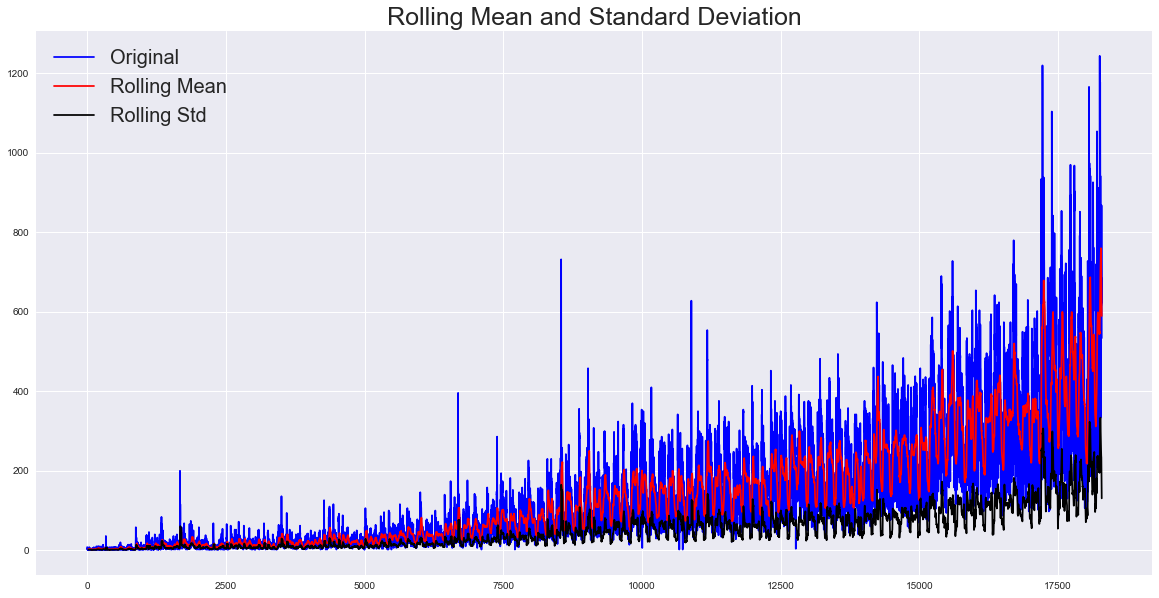

Results of Dickey Fuller Test :

Test Statistic                    -4.456561
P-Value                            0.000235
#Lag Used                         45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [75]:
rcParams['figure.figsize'] = 20,10
test_stationarity(train_original['Count'])

The statistics shows that the time series is stationary as Test Statistic < Critical value but we can see an increasing trend in the data. So, firstly we will try to make the data more stationary. For doing so, we need to remove the trend and seasonality from the data.

**Removing Trend**
* A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear.

* We see an increasing trend in the data so we can apply transformation which penalizes higher values more than smaller ones, for example log transformation.

* We will take rolling average here to remove the trend. We will take the window size of 24 based on the fact that each day has 24 hours.

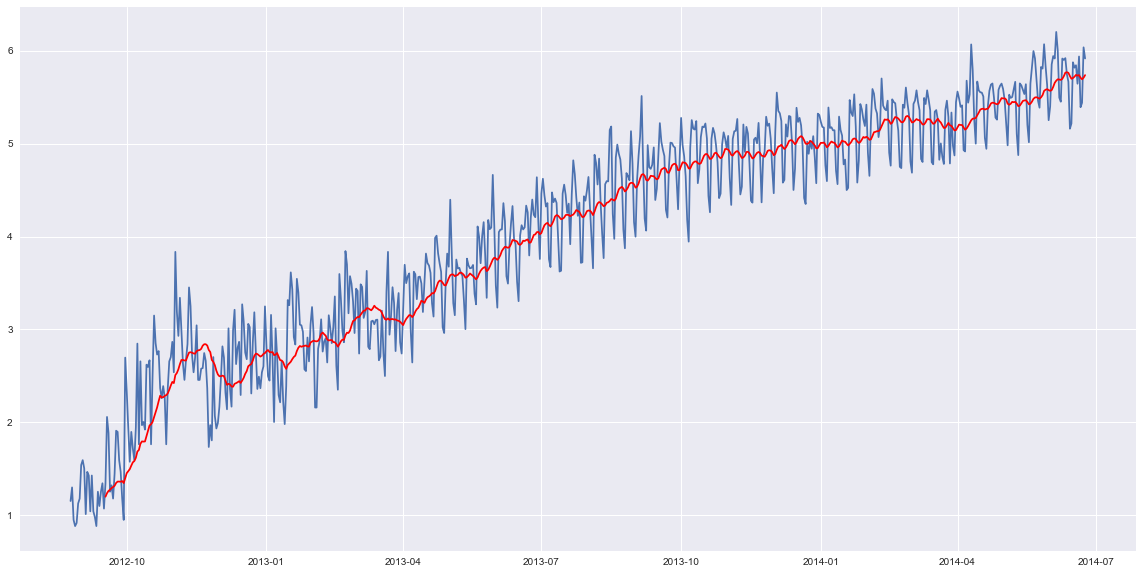

In [76]:
Train_log = np.log(Train['Count'])
valid_log = np.log(valid['Count'])
moving_avg = Train_log.rolling(window= 24).mean()
plt.plot(Train_log)
plt.plot(moving_avg, color= 'red')
plt.show()

So we can observe an increasing trend. Now we will remove this increasing trend to make our time series stationary.

In [77]:
train_log_moving_avg_diff = Train_log - moving_avg

Since we took the average of 24 values, rolling mean is not defined for the first 23 values. So let’s drop those null values.

In [78]:
train_log_moving_avg_diff.dropna(inplace=True)

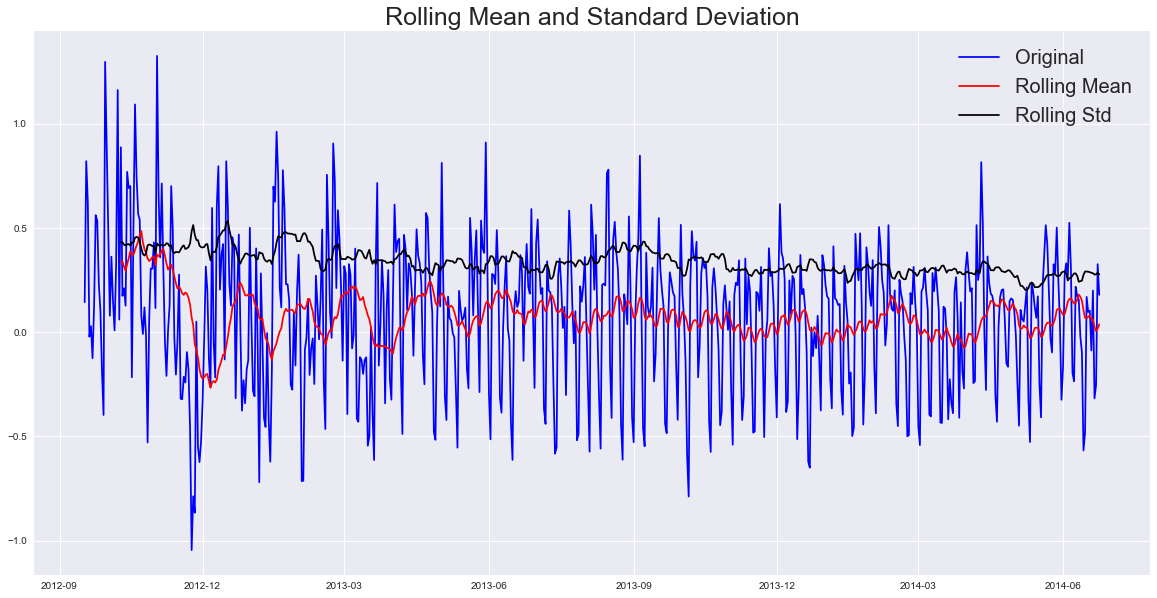

Results of Dickey Fuller Test :

Test Statistic                -5.861646e+00
P-Value                        3.399422e-07
#Lag Used                      2.000000e+01
Number of Observations Used    6.250000e+02
Critical Value (1%)           -3.440856e+00
Critical Value (5%)           -2.866175e+00
Critical Value (10%)          -2.569239e+00
dtype: float64


In [79]:
test_stationarity(train_log_moving_avg_diff)

We can see that the Test Statistic is very smaller as compared to the Critical Value. So, we can be confident that the trend is almost removed.

Let’s now stabilize the mean of the time series which is also a requirement for a stationary time series.

    Differencing can help to make the series stable and eliminate the trend.

In [80]:
train_log_diff = Train_log - Train_log.shift(1)

In [81]:
train_log_diff.dropna(inplace=True)

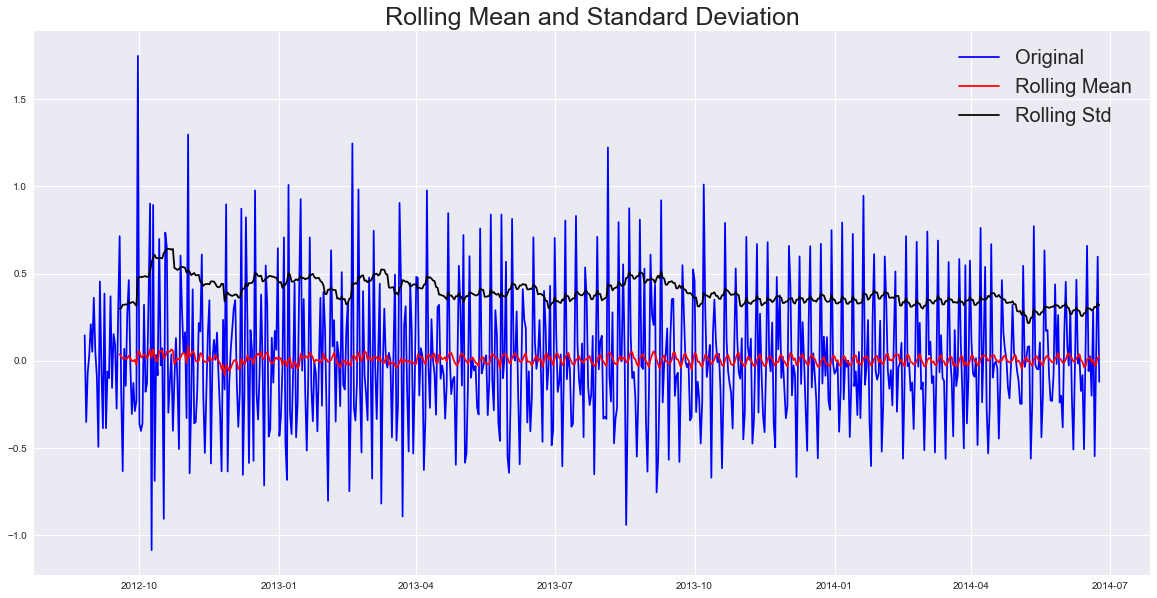

Results of Dickey Fuller Test :

Test Statistic                -8.237568e+00
P-Value                        5.834049e-13
#Lag Used                      1.900000e+01
Number of Observations Used    6.480000e+02
Critical Value (1%)           -3.440482e+00
Critical Value (5%)           -2.866011e+00
Critical Value (10%)          -2.569151e+00
dtype: float64


In [82]:
test_stationarity(train_log_diff)

Now we will decompose the time series into trend and seasonality and will get the residual which is the random variation in the series.

**Removing Seasonality**
* By seasonality, I mean periodic fluctuations. A seasonal pattern exists when a series is influenced by seasonal factors (e.g., the quarter of the year, the month, or day of the week).
* Seasonality is always of a fixed and known period.
* I will use seasonal decompose to decompose the time series into trend, seasonality and residuals.

In [83]:
decomposition = sm.tsa.seasonal_decompose(pd.DataFrame(Train_log)['Count'].values, freq= 24)

In [84]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

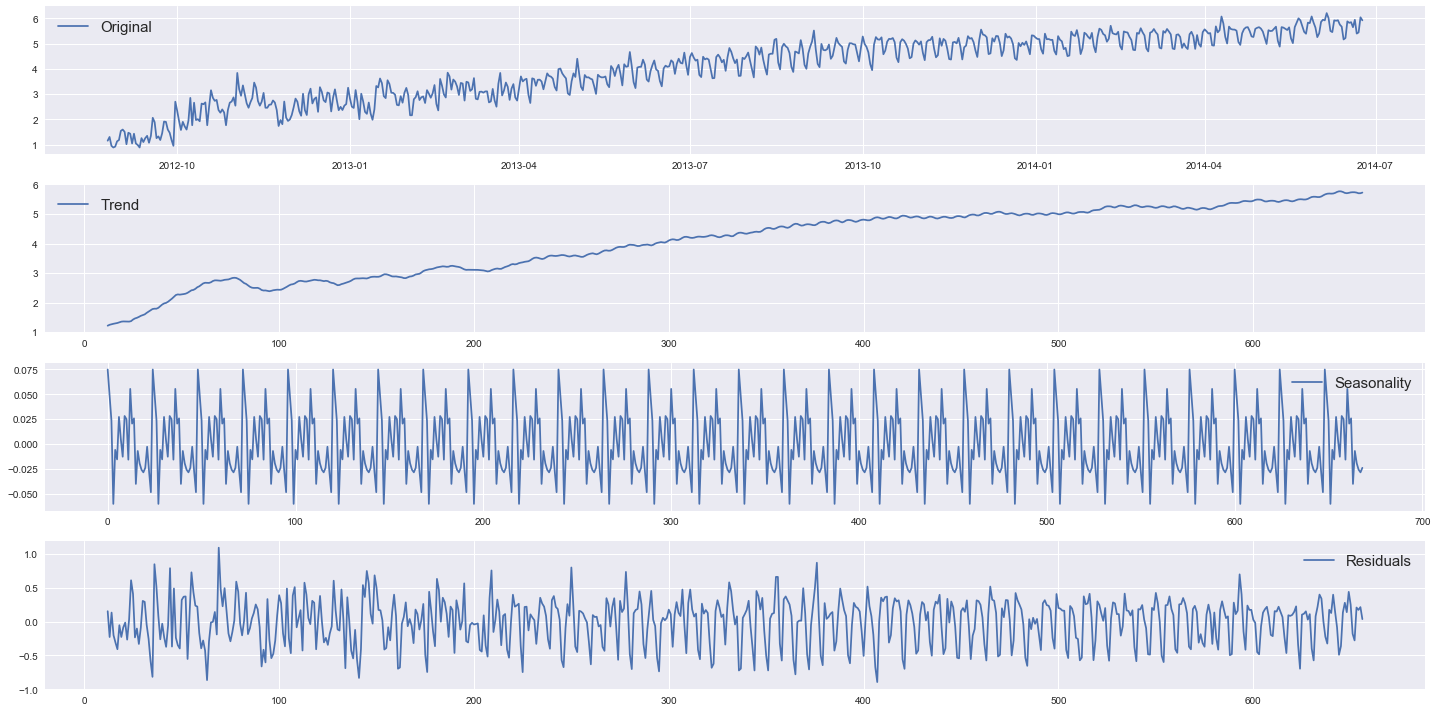

In [85]:
plt.subplot(411)
plt.plot(Train_log, label= 'Original')
plt.legend(loc= 'best', fontsize=15)
plt.subplot(412)
plt.plot(trend, label= 'Trend')
plt.legend(loc= 'best', fontsize=15)
plt.subplot(413)
plt.plot(seasonal, label= 'Seasonality')
plt.legend(loc= 'best', fontsize=15)
plt.subplot(414)
plt.plot(residual, label= 'Residuals')
plt.legend(loc= 'best', fontsize=15)
plt.tight_layout()
plt.show()

Lets check stationarity of residuals

In [86]:
train_log_decompose = pd.DataFrame(residual)
train_log_decompose['date'] = Train_log.index
train_log_decompose.set_index('date',inplace= True)
train_log_decompose.dropna(inplace= True)

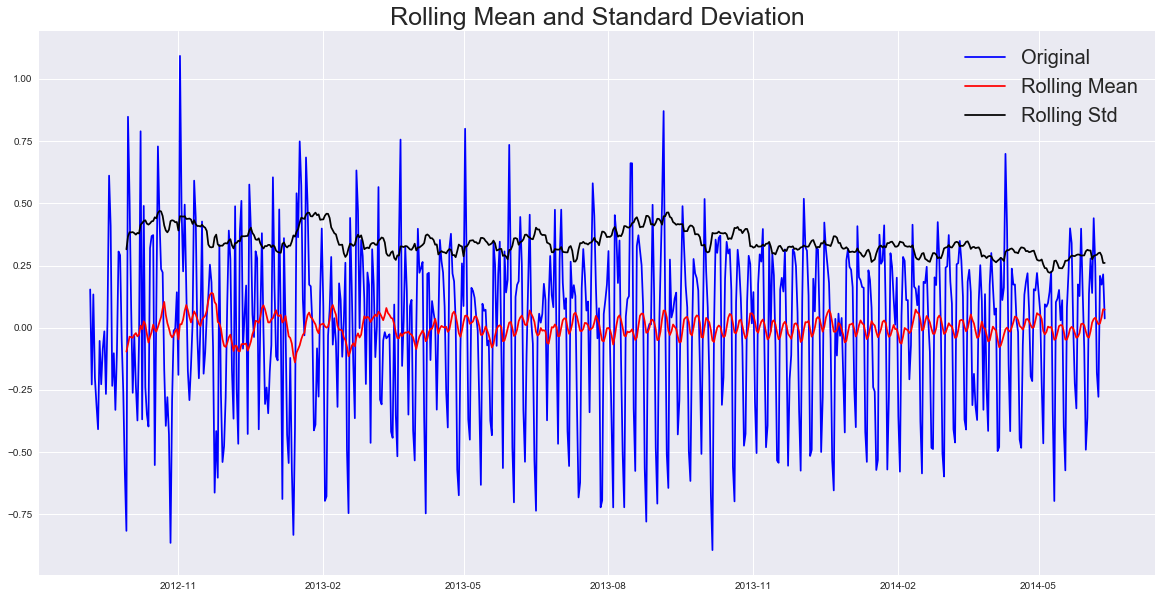

Results of Dickey Fuller Test :

Test Statistic                -7.822096e+00
P-Value                        6.628321e-12
#Lag Used                      2.000000e+01
Number of Observations Used    6.240000e+02
Critical Value (1%)           -3.440873e+00
Critical Value (5%)           -2.866183e+00
Critical Value (10%)          -2.569243e+00
dtype: float64


In [87]:
test_stationarity(train_log_decompose[0])

* It can be interpreted from the results that the residuals are stationary.

* Now we will forecast the time series using different models.

**Forecasting time series using ARIMA**
* First of all we will fit the ARIMA model on our time series for that we have to find the optimized values for the p,d,q parameters.

* To find the optimized values of these parameters, we will use ACF(Autocorrelation Function) and PACF(Partial Autocorrelation Function) graph.

* ACF is a measure of the correlation between the TimeSeries with a lagged version of itself.

* PACF measures the correlation between the TimeSeries with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons.

In [88]:
lag_acf = acf(train_log_diff.dropna(), nlags= 25)
lag_pacf = pacf(train_log_diff.dropna(), nlags= 25, method= 'ols')

**ACF and PACF plots**

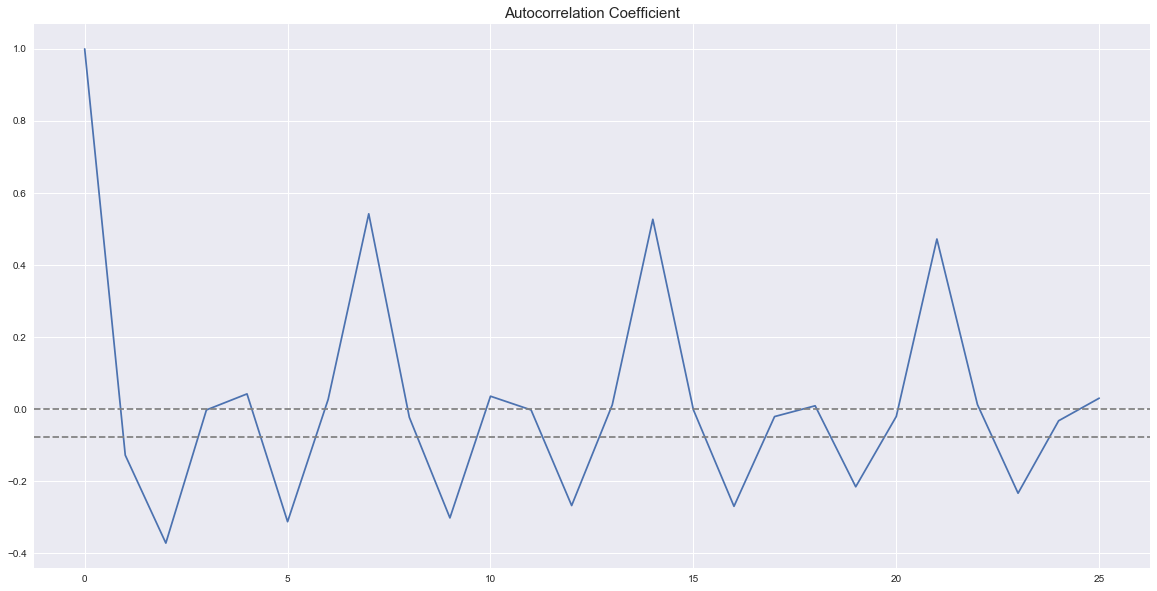

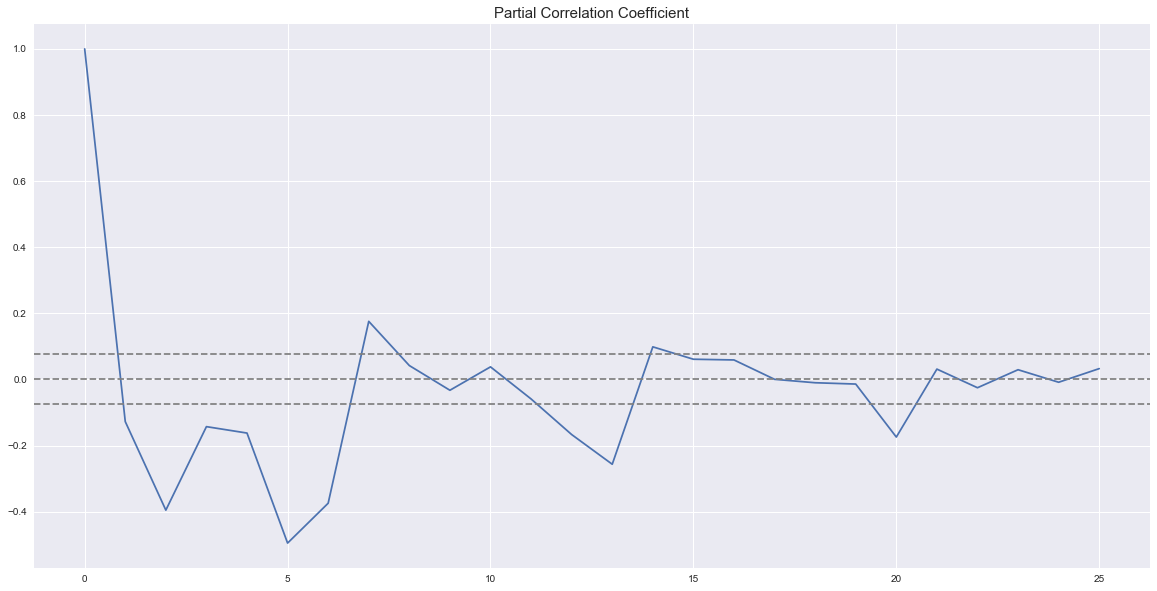

In [89]:
plt.plot(lag_acf)
plt.axhline(y= 0, linestyle= '--', color= 'gray')
plt.axhline(y= -1.96/np.sqrt(len(train_log_diff.dropna())), linestyle= '--', color= 'gray')
plt.title('Autocorrelation Coefficient', fontsize= 15)
plt.show()
plt.plot(lag_pacf)
plt.axhline(y= 0, linestyle= '--', color= 'gray')
plt.axhline(y= -1.96/np.sqrt(len(train_log_diff.dropna())), linestyle= '--', color= 'gray')
plt.axhline(y= 1.96/np.sqrt(len(train_log_diff.dropna())), linestyle= '--', color= 'gray')
plt.title('Partial Correlation Coefficient', fontsize= 15)
plt.show()

* p value is the lag value where the PACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case p=1.

* q value is the lag value where the ACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case q=1.

* Now we will make the ARIMA model as we have the p,q values. We will make the AR and MA model separately and then combine them together.

**AR Model**

The autoregressive model specifies that the output variable depends linearly on its own previous values.

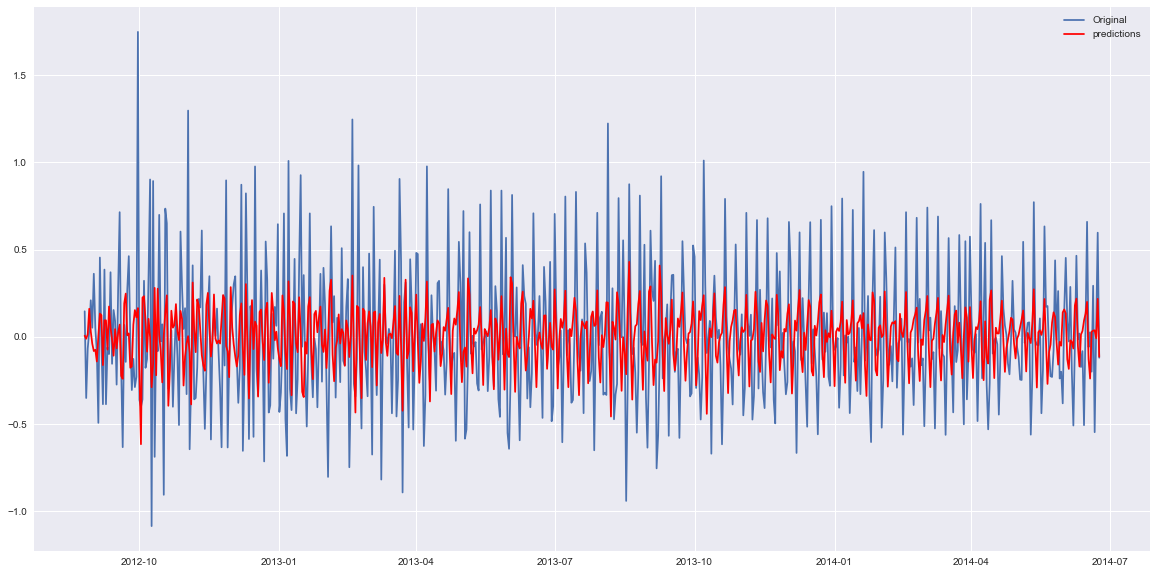

In [90]:
model = ARIMA(Train_log, order= (2,1,0))#q value is 0 since it is an AR model
results_AR = model.fit(disp= -1)
plt.plot(train_log_diff.dropna(), label= 'Original')
plt.plot(results_AR.fittedvalues, color= 'red', label= 'predictions')
plt.legend(loc= 'best')
plt.show()

Lets plot the validation curve for AR model.

We have to change the scale of the model to the original scale.

First step would be to store the predicted results as a separate series and observe it.

In [91]:
AR_predict = results_AR.predict(start = '2014-06-25', end= '2014-09-25')
AR_predict = AR_predict.cumsum().shift().fillna(0)
AR_predict1 = pd.Series(np.ones(valid.shape[0])*np.log(valid['Count'])[0], index= valid.index)
AR_predict1 = AR_predict1.add(AR_predict, fill_value= 0)
AR_predict = np.exp(AR_predict1)

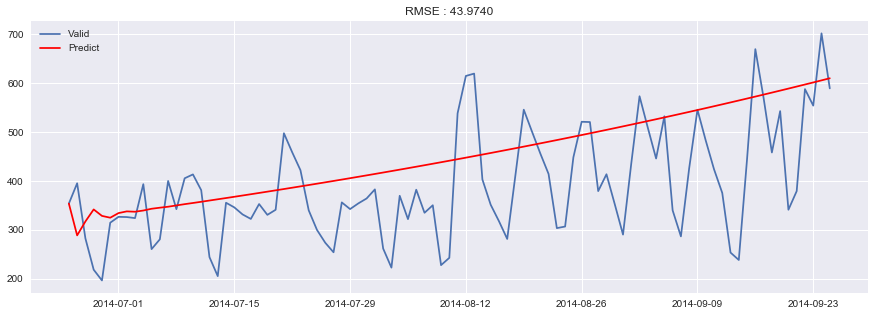

In [92]:
plt.figure(figsize= (15,5))
plt.plot(valid['Count'], label= 'Valid')
plt.plot(AR_predict, color= 'red', label= 'Predict')
plt.legend(loc= 'best')
plt.title('RMSE : %.4f'% (np.sqrt(np.dot(AR_predict, valid['Count']))/valid.shape[0]))
plt.show()

**MA Model**

The moving-average model specifies that the output variable depends linearly on the current and various past values of a stochastic (imperfectly predictable) term.

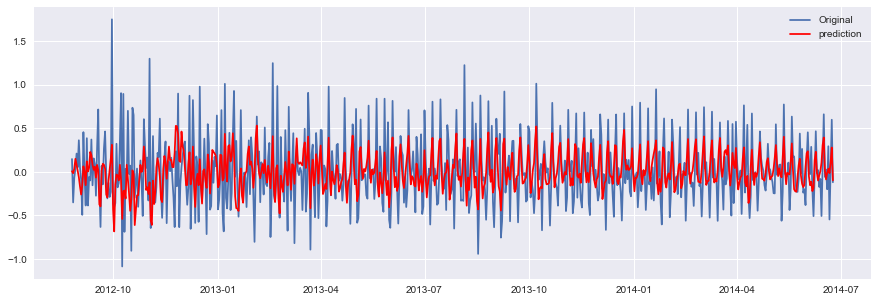

In [93]:
plt.figure(figsize=(15,5))
model = ARIMA(Train_log, order = (0, 1, 2))#here p value is 0 since it is just MA model
results_MA = model.fit(disp= -1)
plt.plot(train_log_diff.dropna(), label= 'Original')
plt.plot(results_MA.fittedvalues, color= 'red', label= 'prediction')
plt.legend(loc= 'best')
plt.show()

In [94]:
MA_predict = results_MA.predict(start= '2014-06-25', end= '2014-09-25')
MA_predict = MA_predict.cumsum().shift().fillna(0)
MA_predict1 = pd.Series(np.ones(valid.shape[0])*np.log(valid['Count'])[0], index= valid.index)
MA_predict1 = MA_predict1.add(MA_predict, fill_value= 0)
MA_predict = np.exp(MA_predict1)

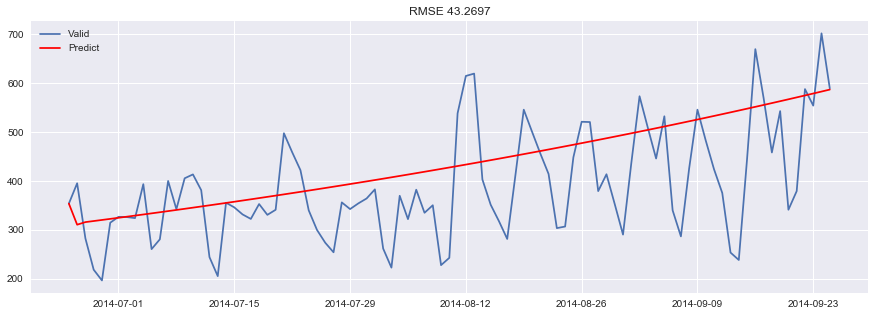

In [95]:
plt.figure(figsize=(15,5))
plt.plot(valid['Count'], label= 'Valid')
plt.plot(MA_predict, color= 'red', label= 'Predict')
plt.legend(loc= 'best')
plt.title('RMSE %.4f'%(np.sqrt(np.dot(MA_predict, valid['Count']))/valid.shape[0]))
plt.show()

**Combined Model**

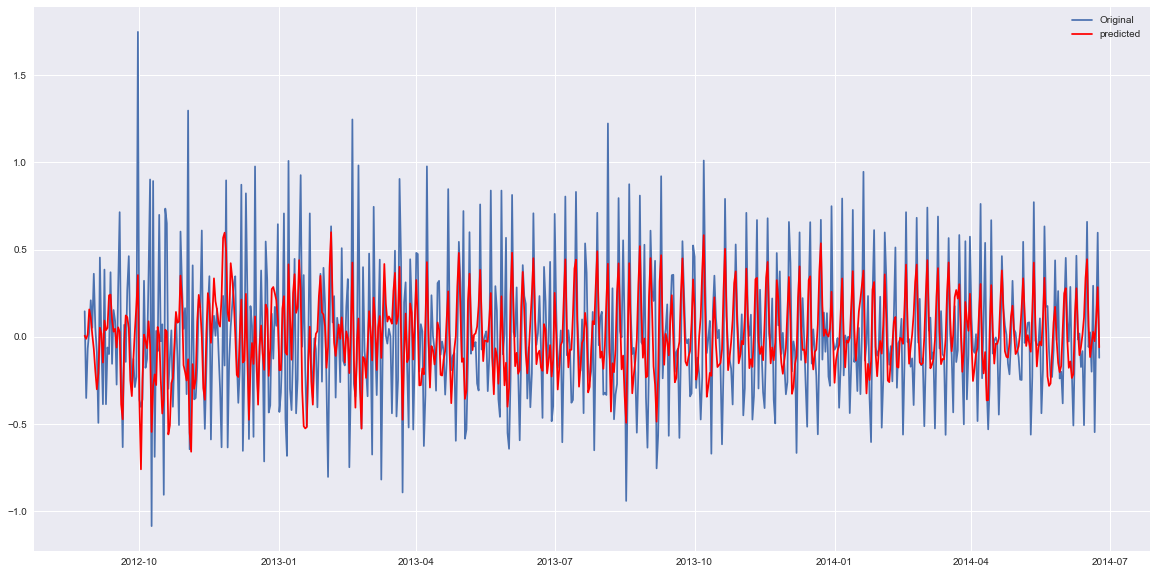

In [96]:
model = ARIMA(Train_log, order= (2, 1, 2))
results_ARIMA = model.fit(disp= -1)
plt.plot(train_log_diff.dropna(), label= 'Original')
plt.plot(results_ARIMA.fittedvalues, color= 'red', label= 'predicted')
plt.legend(loc= 'best')
plt.show()

Let’s define a function which can be used to change the scale of the model to the original scale.

In [97]:
def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['Count'])[0], index = given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)
    plt.plot(given_set['Count'], label= 'Given Set')
    plt.plot(predict, color= 'red', label= 'Predict')
    plt.legend(loc= 'best')
    plt.title('RMSE : %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()

In [98]:
def check_prediction_log(predict_log, given_set):
    predict= np.exp(predict_log)
    plt.plot(given_set['Count'], label= 'Given Set')
    plt.plot(predict, color= 'red', label= 'Predict')
    plt.legend(loc= 'best')
    plt.title('RMSE : %.4f'%(np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()

Let’s predict the values for validation set.

In [99]:
ARIMA_predict_diff = results_ARIMA.predict(start= '2014-06-25', end= '2014-09-25')

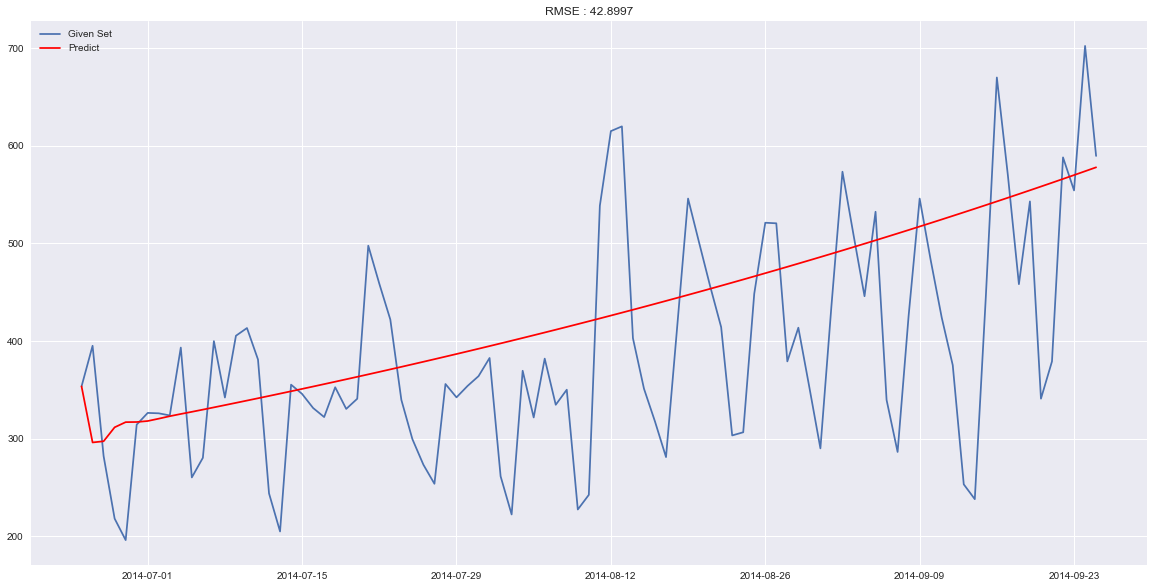

In [100]:
check_prediction_diff(ARIMA_predict_diff, valid)

### SARIMAX Model on daily time series
SARIMAX model takes into account the seasonality of the time series. So we will build a SARIMAX model on the time series.

C:\Users\Aditya\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


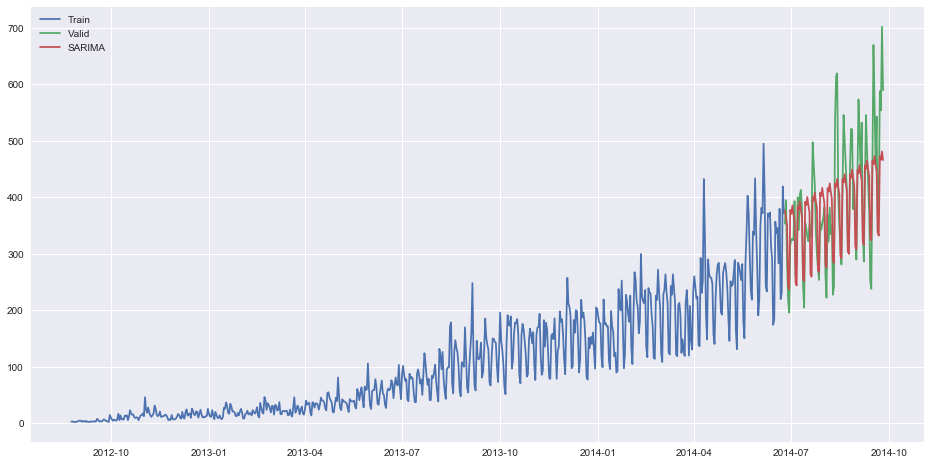

In [101]:
y_hat_avg = valid.copy()
fit1 = sm.tsa.statespace.SARIMAX(Train['Count'], order= (2, 1, 4), seasonal_order= (0,1,1,7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start= '2014-06-25', end= '2014-09-25', dynamic= True)
plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label= 'Train')
plt.plot(valid['Count'], label= 'Valid')
plt.plot(y_hat_avg['SARIMA'], label= 'SARIMA')
plt.legend(loc= 'best')
plt.show()

* Order in the above model represents the order of the autoregressive model(number of time lags), the degree of differencing(number of times the data have had past values subtracted) and the order of moving average model.

* Seasonal order represents the order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity.

* In our case the periodicity is 7 since it is daily time series and will repeat after every 7 days.

Let’s check the rmse value for the validation part.

In [102]:
rms = sqrt(mean_squared_error(valid['Count'], y_hat_avg['SARIMA']))
print(rms)

69.81058494793194


In [103]:
# forecast the time series for Test data which starts from 2014-9-26 and ends at 2015-4-26.
predict = fit1.predict(start = '2014-09-26',end= '2015-04-26', dynamic= True)

Note that these are the daily predictions and we need hourly predictions. So, we will distribute this daily prediction into hourly counts. To do so, we will take the ratio of hourly distribution of passenger count from train data and then we will distribute the predictions in the same ratio.

In [104]:
test['prediction'] = predict
# Merge Test and test_original on day, month and year 
merge = pd.merge(test, test_original, on= ('day','month','year'), how= 'left')
merge['Hour'] = merge['Hour_y']
merge = merge.drop(['year','month','Datetime','Hour_x','Hour_y'], axis= 1)
#predicting by merging merge and temp2
prediction = pd.merge(merge, temp2, on= 'Hour', how= 'left')
#converting the ratio to original scale
prediction['Count'] = prediction['prediction']*prediction['ratio']*24

In [105]:
#drop all variables other than ID and Count
prediction['ID'] = prediction['ID_y']
submission = prediction.drop(['day','Hour','ratio','prediction','ID_x','ID_y'], axis= 1)

In [106]:
#converting the final submission to csv format
pd.DataFrame(submission, columns=['ID','Count']).to_csv('SARIMAX.csv')